In [ ]:
import pandas as pd
import torch
import json
from torch.utils.data import Dataset, DataLoader
from transformers import DebertaTokenizer, DebertaForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, average_precision_score, matthews_corrcoef, confusion_matrix, roc_curve, precision_recall_curve
from torch.utils.data import Dataset
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Load the data
with open('/content/Ecare_2.jsonl', 'r') as f:
    ecare_1 = [json.loads(line) for line in f]

# Define split sizes for a 75-25 split of the data
train_size = int(0.75 * len(ecare_1))
train_data = ecare_1[:train_size]
validation_data = ecare_1[train_size:]

class EcareDataset(Dataset):
    def __init__(self, ecare_data, tokenizer):
        self.ecare_data = ecare_data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.ecare_data)

    def __getitem__(self, idx):
        data = self.ecare_data[idx]
        premise = data['premise']
        hypotheses = [data['hypothesis1'], data['hypothesis2']]
        label = data['label']

        encoded_input = self.tokenizer(premise, hypotheses, padding='max_length', truncation=True, max_length=512, return_tensors='pt')
        input_ids = encoded_input['input_ids'].squeeze(0)
        attention_mask = encoded_input['attention_mask'].squeeze(0)
        label = torch.tensor(label)

        return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': label}

# Load tokenizer and model
tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')
model = DebertaForSequenceClassification.from_pretrained('microsoft/deberta-base', num_labels=2)

ecare_dataset = EcareDataset(train_data, tokenizer)
dataloader = DataLoader(ecare_dataset, batch_size=8, shuffle=True)

optimizer = optim.Adam(model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Training loop
model.train()
for epoch in range(3):
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        print(f"Epoch: {epoch}, Loss: {loss.item()}")

validation_dataset = EcareDataset(validation_data, tokenizer)
validation_dataloader = DataLoader(validation_dataset, batch_size=64)

model.eval()
y_true, y_pred, y_scores = [], [], []

def compute_metrics(y_true, y_pred, y_prob):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_prob)
    pr_auc = average_precision_score(y_true, y_prob)
    mcc = matthews_corrcoef(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    return accuracy, f1, precision, recall, roc_auc, pr_auc, mcc, conf_matrix

with torch.no_grad():
    for batch in validation_dataloader:
        input_ids = batch['input_ids'].squeeze(1)
        attention_mask = batch['attention_mask'].squeeze(1)
        labels = batch['labels']

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=1)
        y_scores_batch = torch.softmax(outputs.logits, dim=1)[:, 1].cpu().numpy()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())
        y_scores.extend(y_scores_batch)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.bias', 'classifier.bias', 'pooler.dense.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: 0, Loss: 0.7259179353713989
Epoch: 0, Loss: 0.6871374249458313
Epoch: 0, Loss: 0.6881699562072754
Epoch: 0, Loss: 0.6726198196411133
Epoch: 0, Loss: 0.7037140727043152
Epoch: 0, Loss: 0.6866106986999512
Epoch: 0, Loss: 0.6699922680854797
Epoch: 0, Loss: 0.7313756942749023
Epoch: 0, Loss: 0.7072722315788269
Epoch: 0, Loss: 0.7175776958465576
Epoch: 0, Loss: 0.708101212978363
Epoch: 0, Loss: 0.6658098697662354
Epoch: 0, Loss: 0.6820141673088074
Epoch: 0, Loss: 0.6306227445602417
Epoch: 0, Loss: 0.7073718309402466
Epoch: 0, Loss: 0.7092509269714355
Epoch: 0, Loss: 0.6847231984138489
Epoch: 0, Loss: 0.6435467600822449
Epoch: 0, Loss: 0.716946005821228
Epoch: 0, Loss: 0.7346020936965942
Epoch: 0, Loss: 0.6805564761161804
Epoch: 0, Loss: 0.6876184344291687
Epoch: 0, Loss: 0.6850855946540833
Epoch: 0, Loss: 0.7226956486701965
Epoch: 0, Loss: 0.6698801517486572
Epoch: 0, Loss: 0.6931791305541992
Epoch: 0, Loss: 0.6952822804450989
Epoch: 0, Loss: 0.694790244102478
Epoch: 0, Loss: 0.71027

In [ ]:
# Calculate metrics
accuracy, f1, precision, recall, roc_auc, pr_auc, mcc, conf_matrix = compute_metrics(y_true, y_pred, y_scores)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")
print(f"MCC: {mcc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.4880
F1: 0.6559
Precision: 0.4880
Recall: 1.0000
ROC-AUC: 0.4796
PR-AUC: 0.4843
MCC: 0.0000
Confusion Matrix:
[[  0 128]
 [  0 122]]


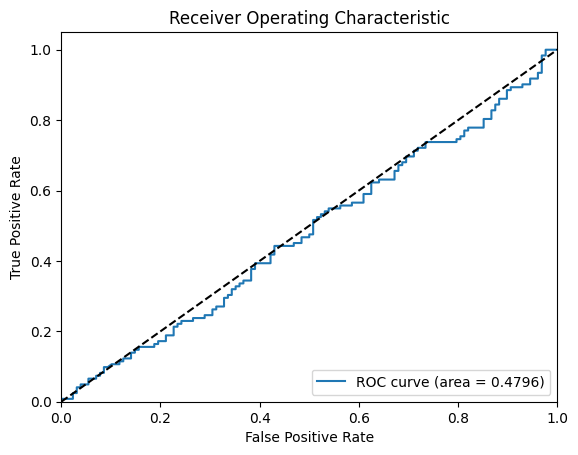

In [ ]:
# Plot ROC-AUC curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
plt.figure(1)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

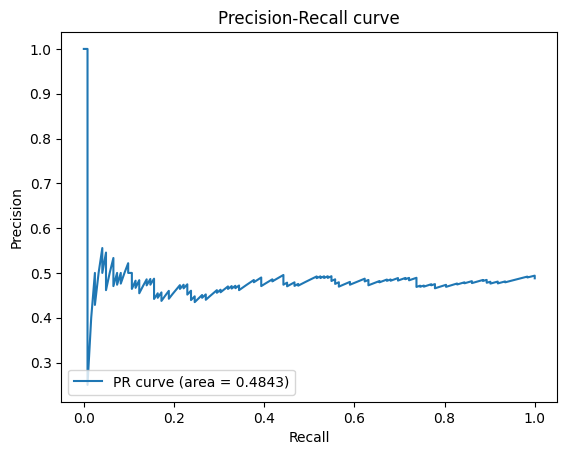

In [ ]:
# Plot PR-AUC curve
precision_array, recall_array, _ = precision_recall_curve(y_true, y_scores)
plt.figure(2)
plt.plot(recall_array, precision_array, label=f'PR curve (area = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.show()